# 7. Testing the inverse strategies - Bootstrapping

In [1]:
import os
import pickle
import sys
cwd = os.getcwd()

module_path = cwd.replace("tutorials", "")
module_path = os.path.join(module_path, "src", "ocloc")
if module_path not in sys.path:
    sys.path.append(module_path)
import ocloc

station_file = os.path.join(cwd, "station_info")
path2data_dir = os.path.abspath(os.path.join(cwd ,"../.."))
path2data_dir = os.path.join(path2data_dir, "data")
print("Path to data directory: ", path2data_dir)

with open('ClockDrift.obj', 'rb') as inp:
    cd = pickle.load(inp)

# If you want to store the object you can do so by uncommenting the following lines:
#import pickle 
#filehandler = open("ClockDrift.obj", 'wb') 
#pickle.dump(cd, filehandler)

Path to data directory:  /Users/localadmin/Dropbox/GitHub/data


**Note:** If the path to the data directory in your computer is different please run the following command with the correct path:

`cd.set_stations(station_file, path2data_dir)`

`cd.set_correlations(path2data_dir)`

`cd.path2data_dir = path2data_dir`

### Running the code following the different steps in our paper

1. Calculate the apriori dt

In [2]:
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()

Calculating the apriori estimates for each stationpair


2. Calculate the time shift of the cross-correlation a.k.a. $t^{+, app}_{i, j} + t^{-, app}_{i, j}$

In [3]:
cd.calculate_tapp_4_allcorrelations()
cd.calculate_dt_ins()

Calculating the t_app for each stationpair.


3. Filter stations with not enough cross-correlations, not enough time distribution of the cross-correlations, or not enough correlations with other stations.

In [4]:
min_number_of_total_correlations = 4
min_number_correlation_periods = 2
min_number_of_stationconnections = 3
average_dates = [c.average_date for c in cd.correlations]
days_apart=(max(average_dates) - min(average_dates)) / (3 * 86400)
cd.filter_stations(min_number_of_total_correlations,
                   min_number_correlation_periods, 
                   min_number_of_stationconnections,
                   days_apart)
# cd.remove_outiers(max_error=1.)

Station  O02 does not exceed the min. no. of correlation.
Station  O02 does not exceed the min. no. of correlation periods.
Station  O02 does not exceed the min_number_of_stationconnections


4. Build the matrices and calculate the a and b values for each station.

In [5]:
cd.build_matrices()
cd.solve_eq()

No t_app found for Station: O02
Calculating a and b for each station.


# Convergence
We can run several inversions until the a and b values stop changing.
This can be checked by plotting the a's and b's of each station and looking for results that do not change anymore.


In [6]:
for i in range(3):
    cd.calculate_tapp_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.remove_outiers(max_error=1.)
    cd.calculate_dt_ins()
    cd.build_matrices()
    cd.solve_eq(method="weighted_lstsq")
    cd.remove_outiers(max_error=1.)

Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.


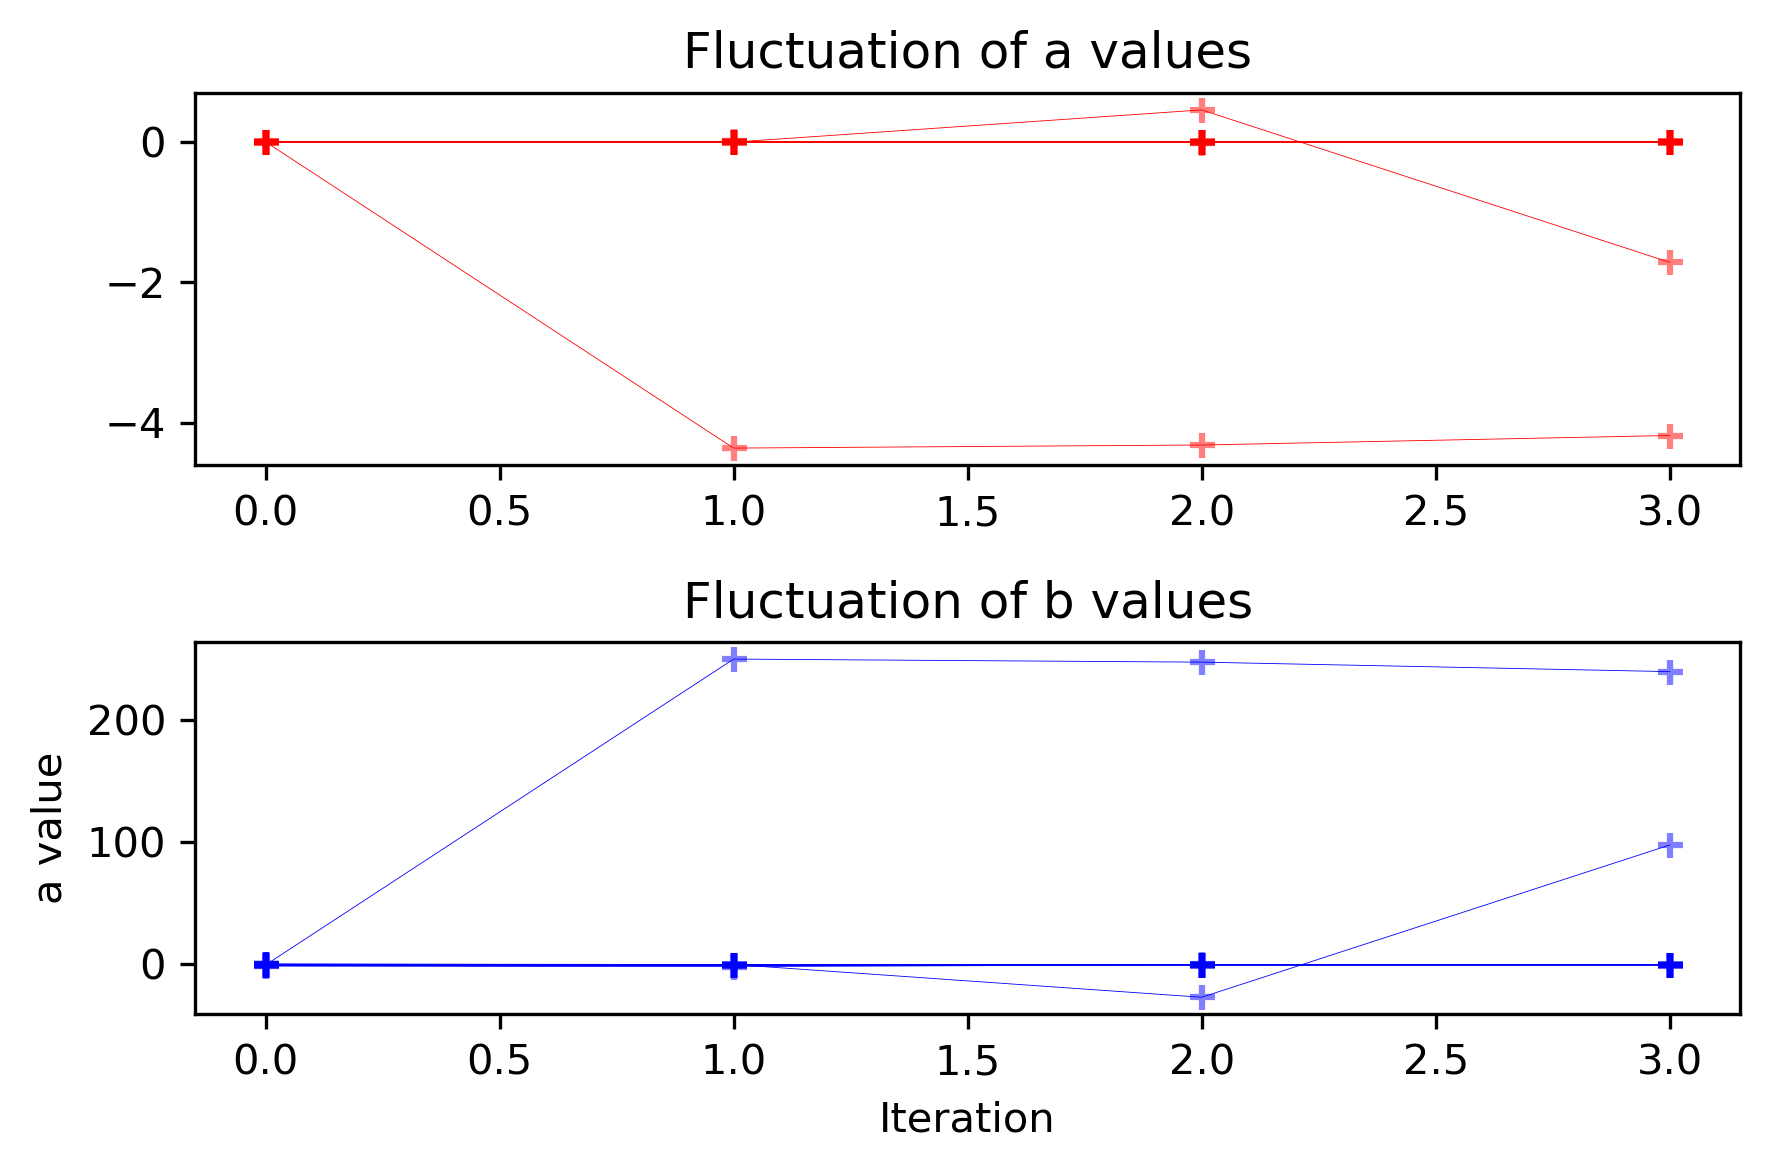

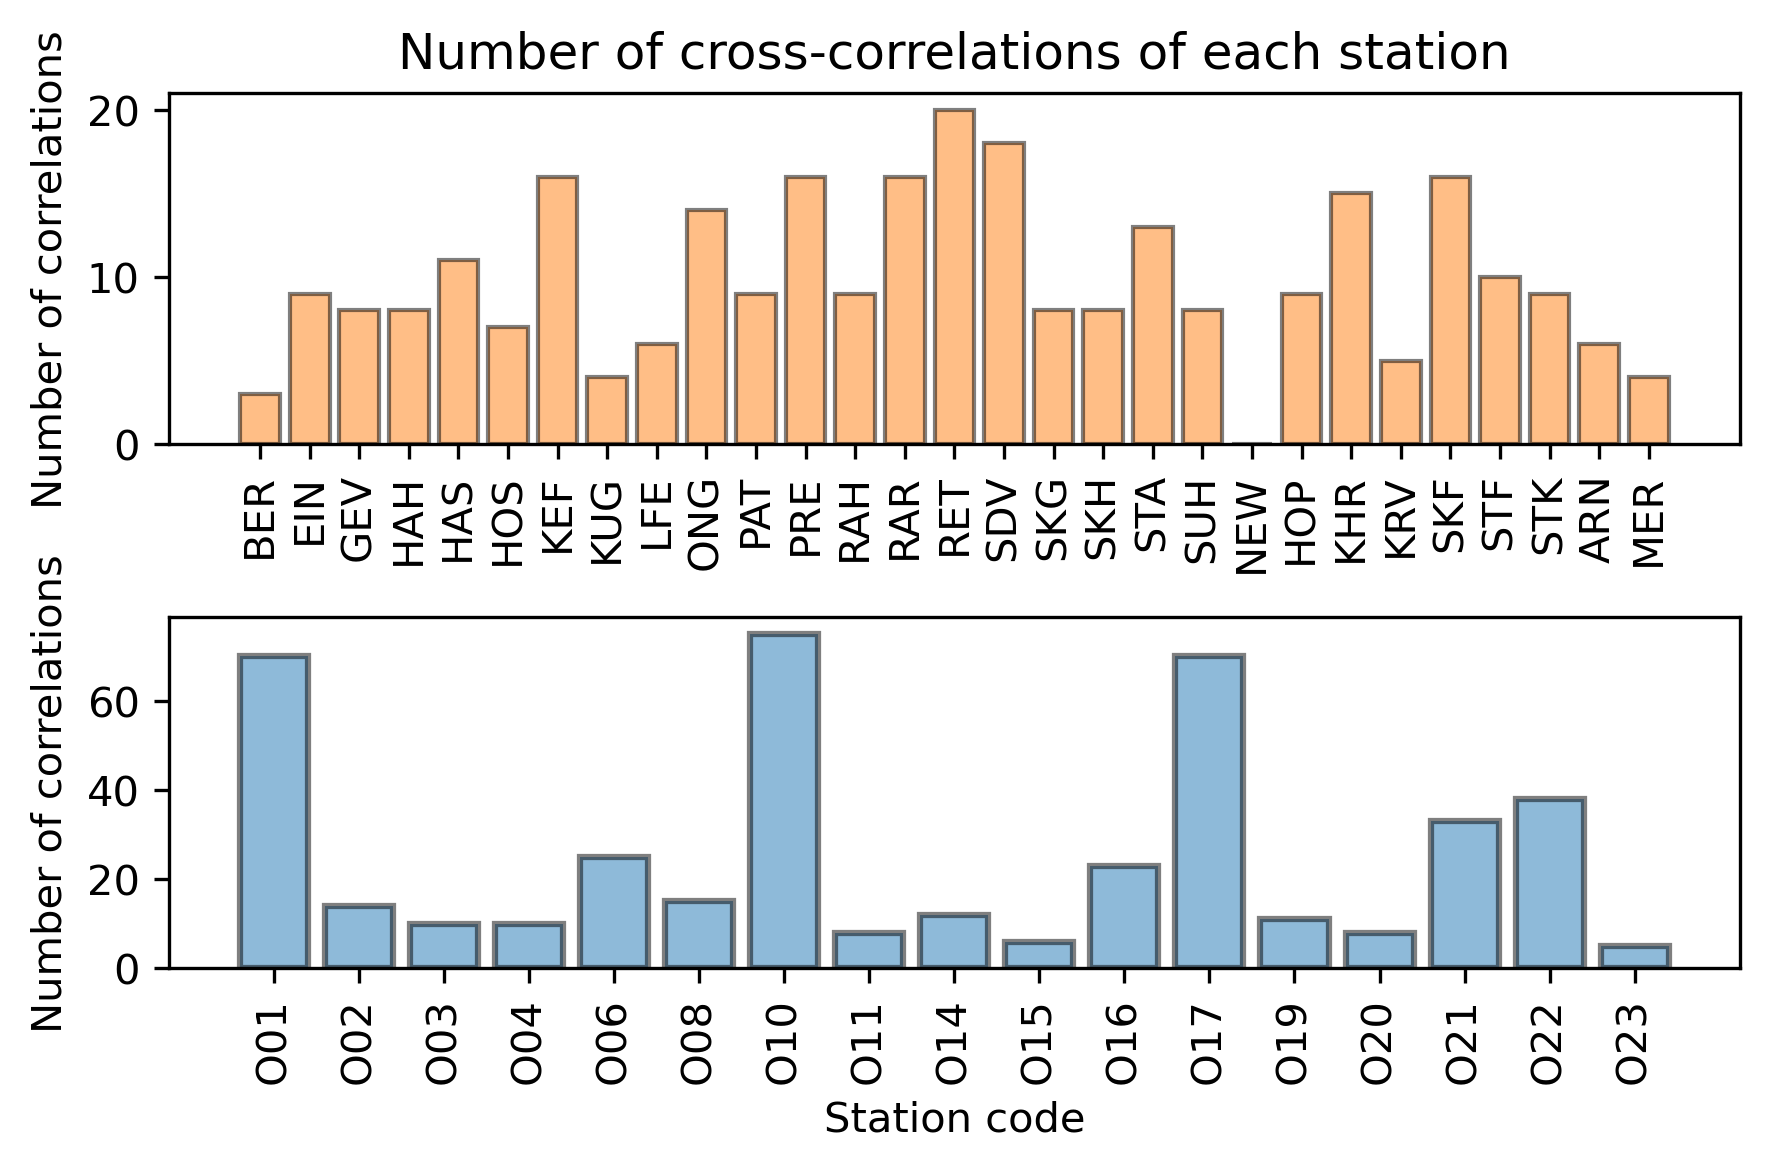

In [7]:
cd.plot_fluctuation_of_a_and_b()
cd.plot_hist_no_correlations_per_station()

# Checking that the corrections we are applying are not introducing errors into our data.

For checking our intermidiate results is critical to check that the waveforms of different time-lapses align in a better way than before starting our operation.

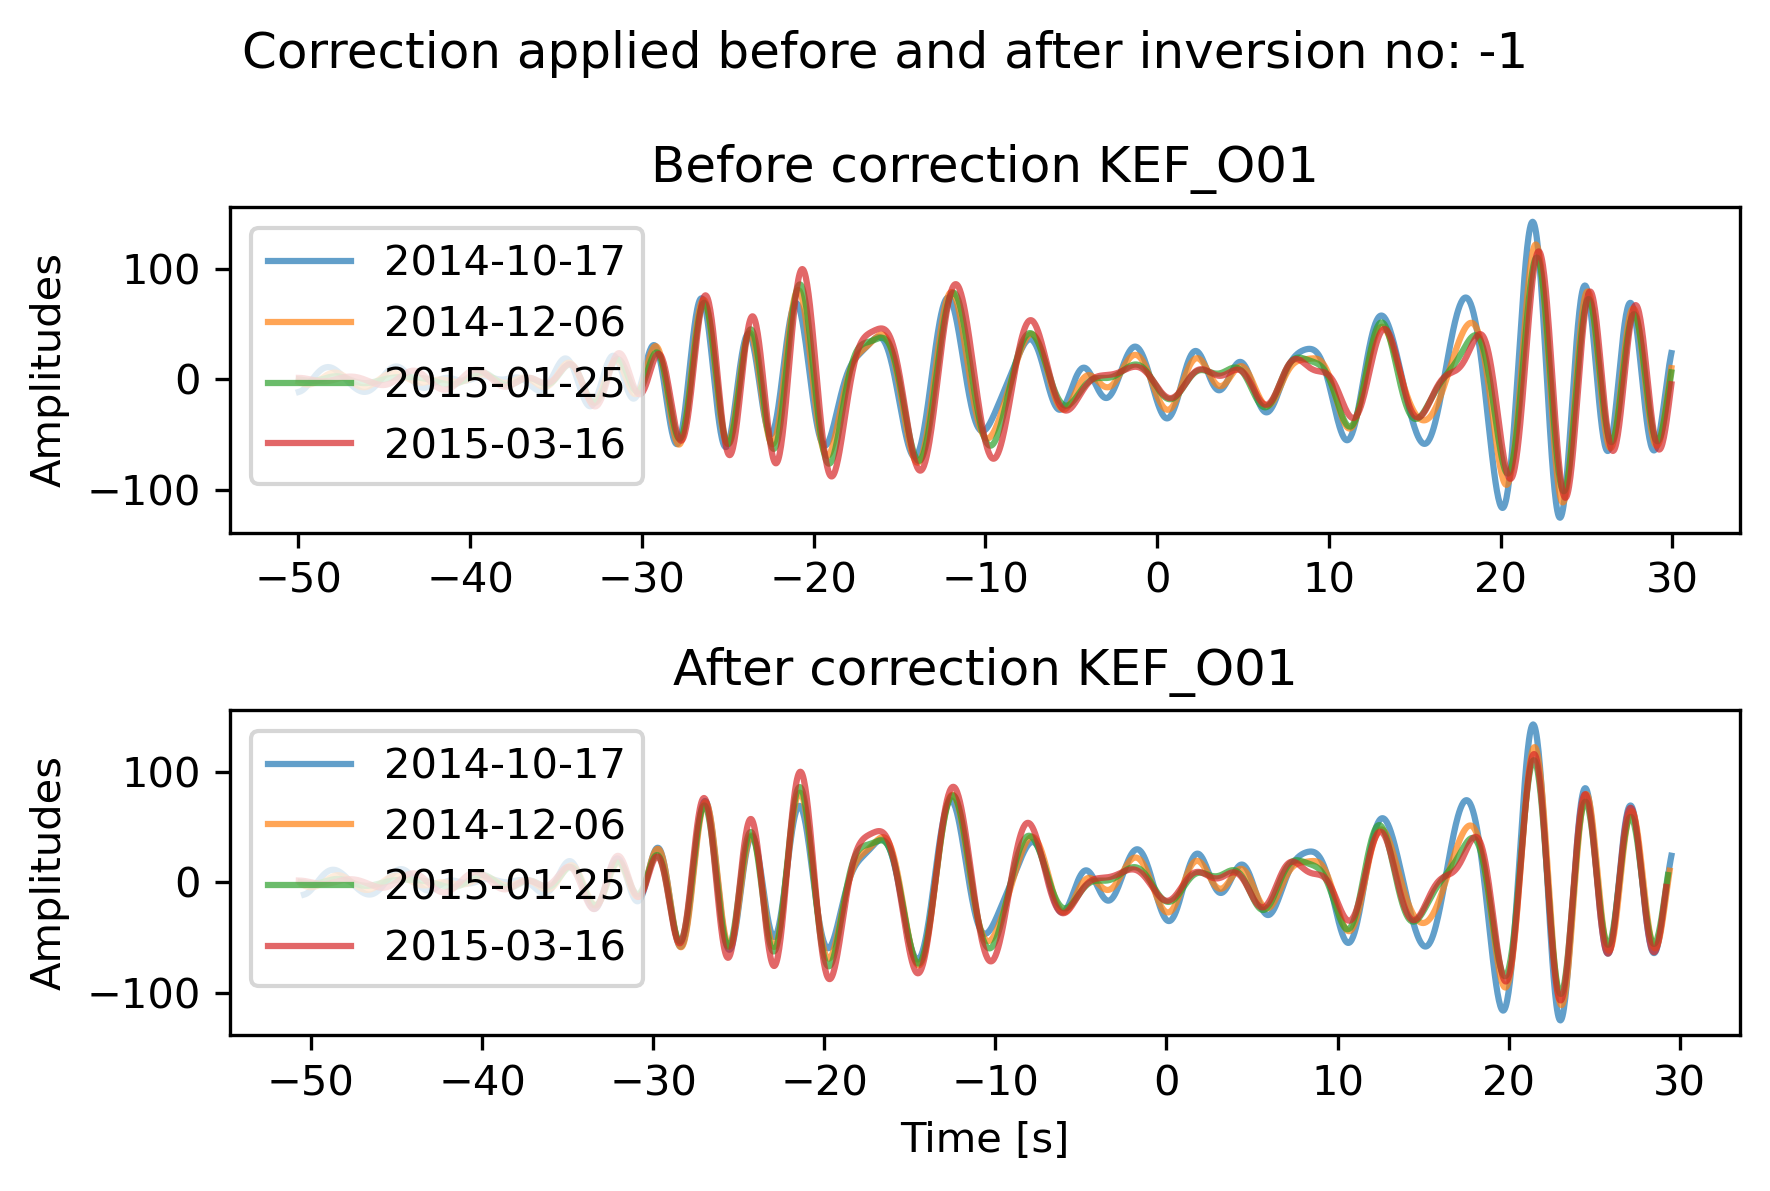

In [8]:
for sta in cd.stations:
    if sta.needs_correction:
        cd.plot_correlation_beforeNafter_correction(sta.code, "KEF")
        break

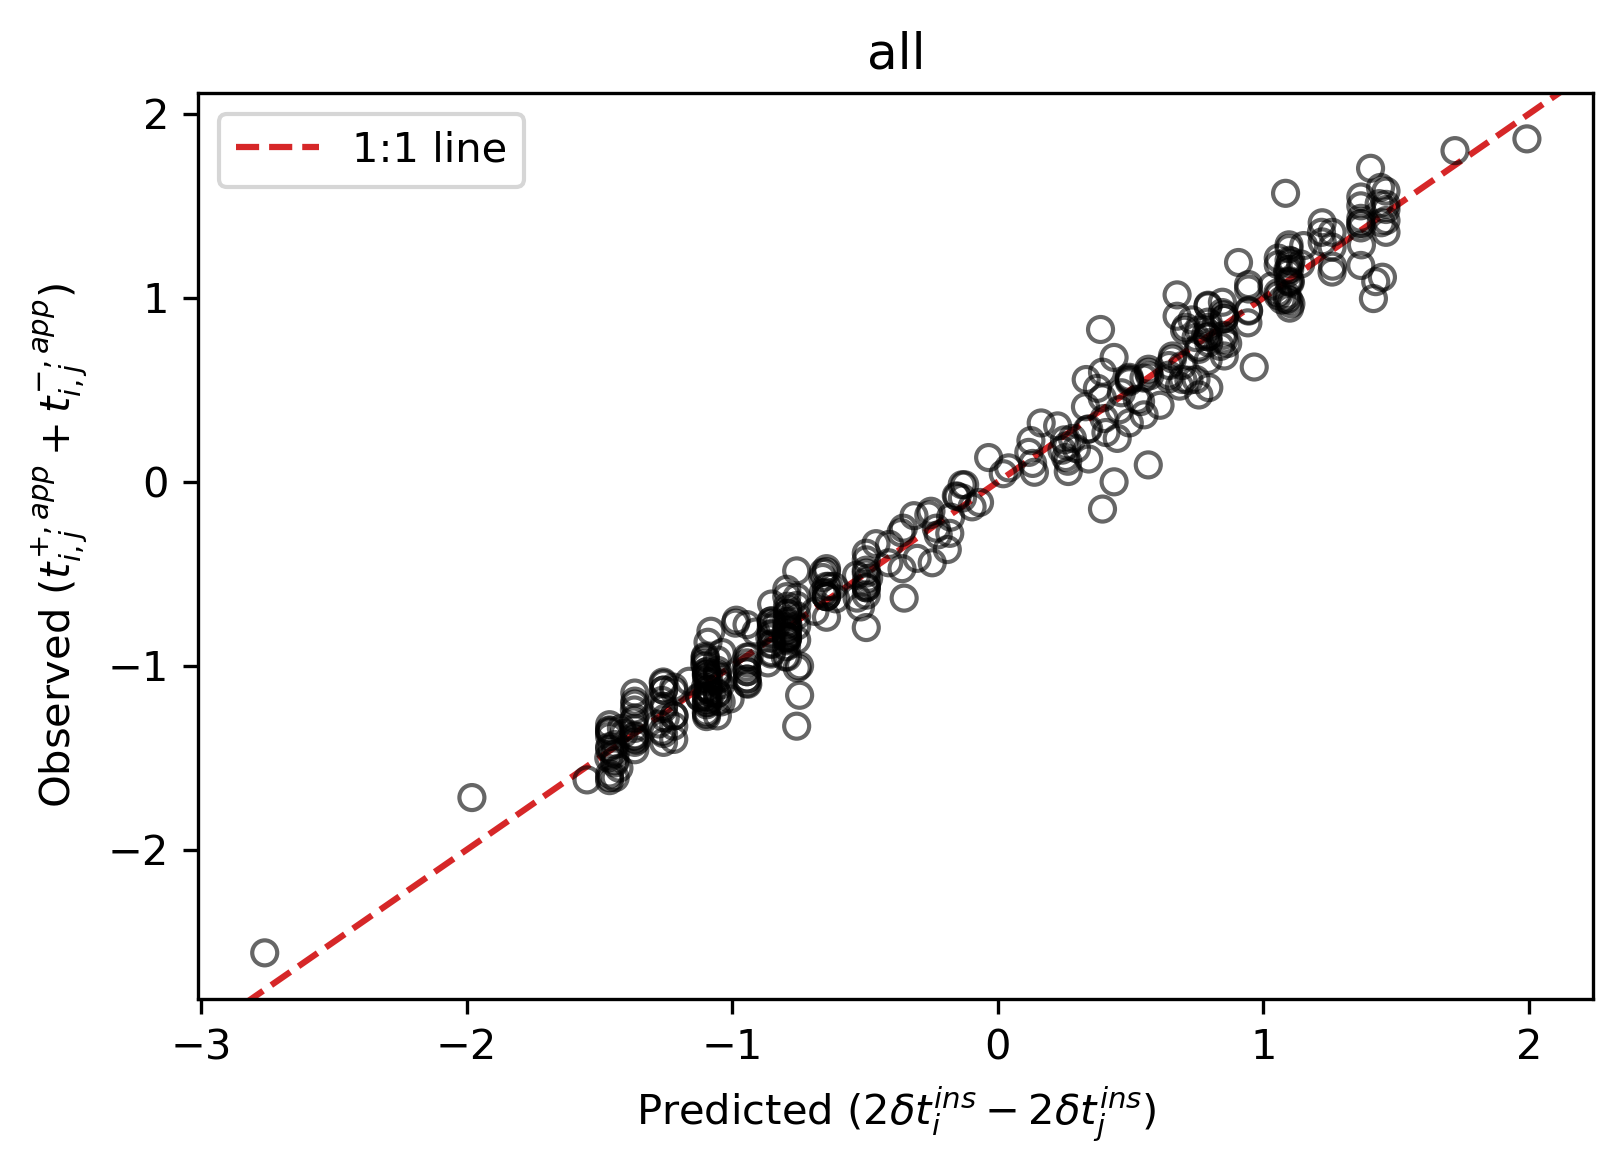

In [9]:
cd.plot_observed_vs_predicted()

# Inversion strategies tested with bootstrapping

We now compare the results from a weighted least squares inversion with the regular least squares inverison.

Bootstrapping is a kind of resampling. The idea is that we treat the sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement. DataFrame provides a method called sample we can use to select a random sample of the rows (Downey, 2020).

From the x measurements we select a subset of x measurements and we invert.
We store the mean a value and mean b value.
Then we repeat.

Remove the stations with very few correlations entirely before doing bootstrapping.

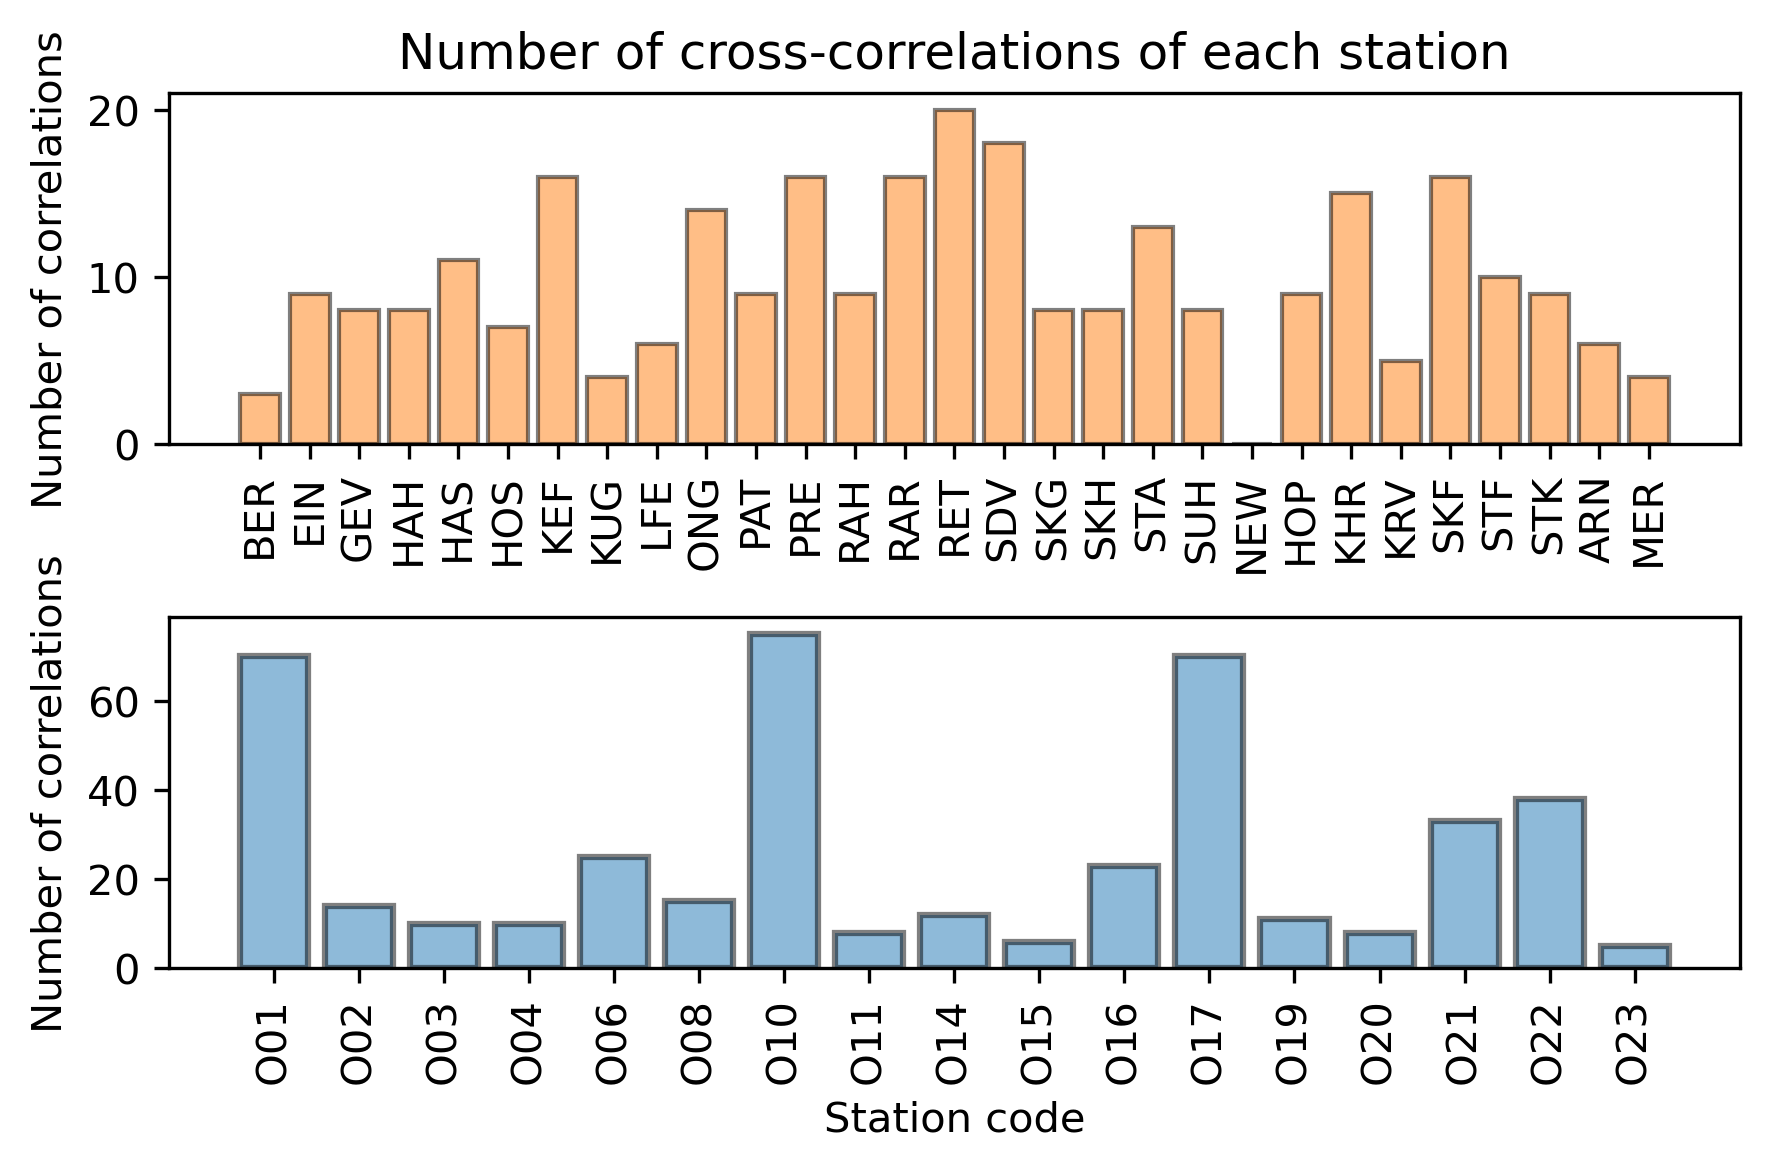

In [10]:
cd.plot_hist_no_correlations_per_station()

Calculating the t_app for each stationpair.


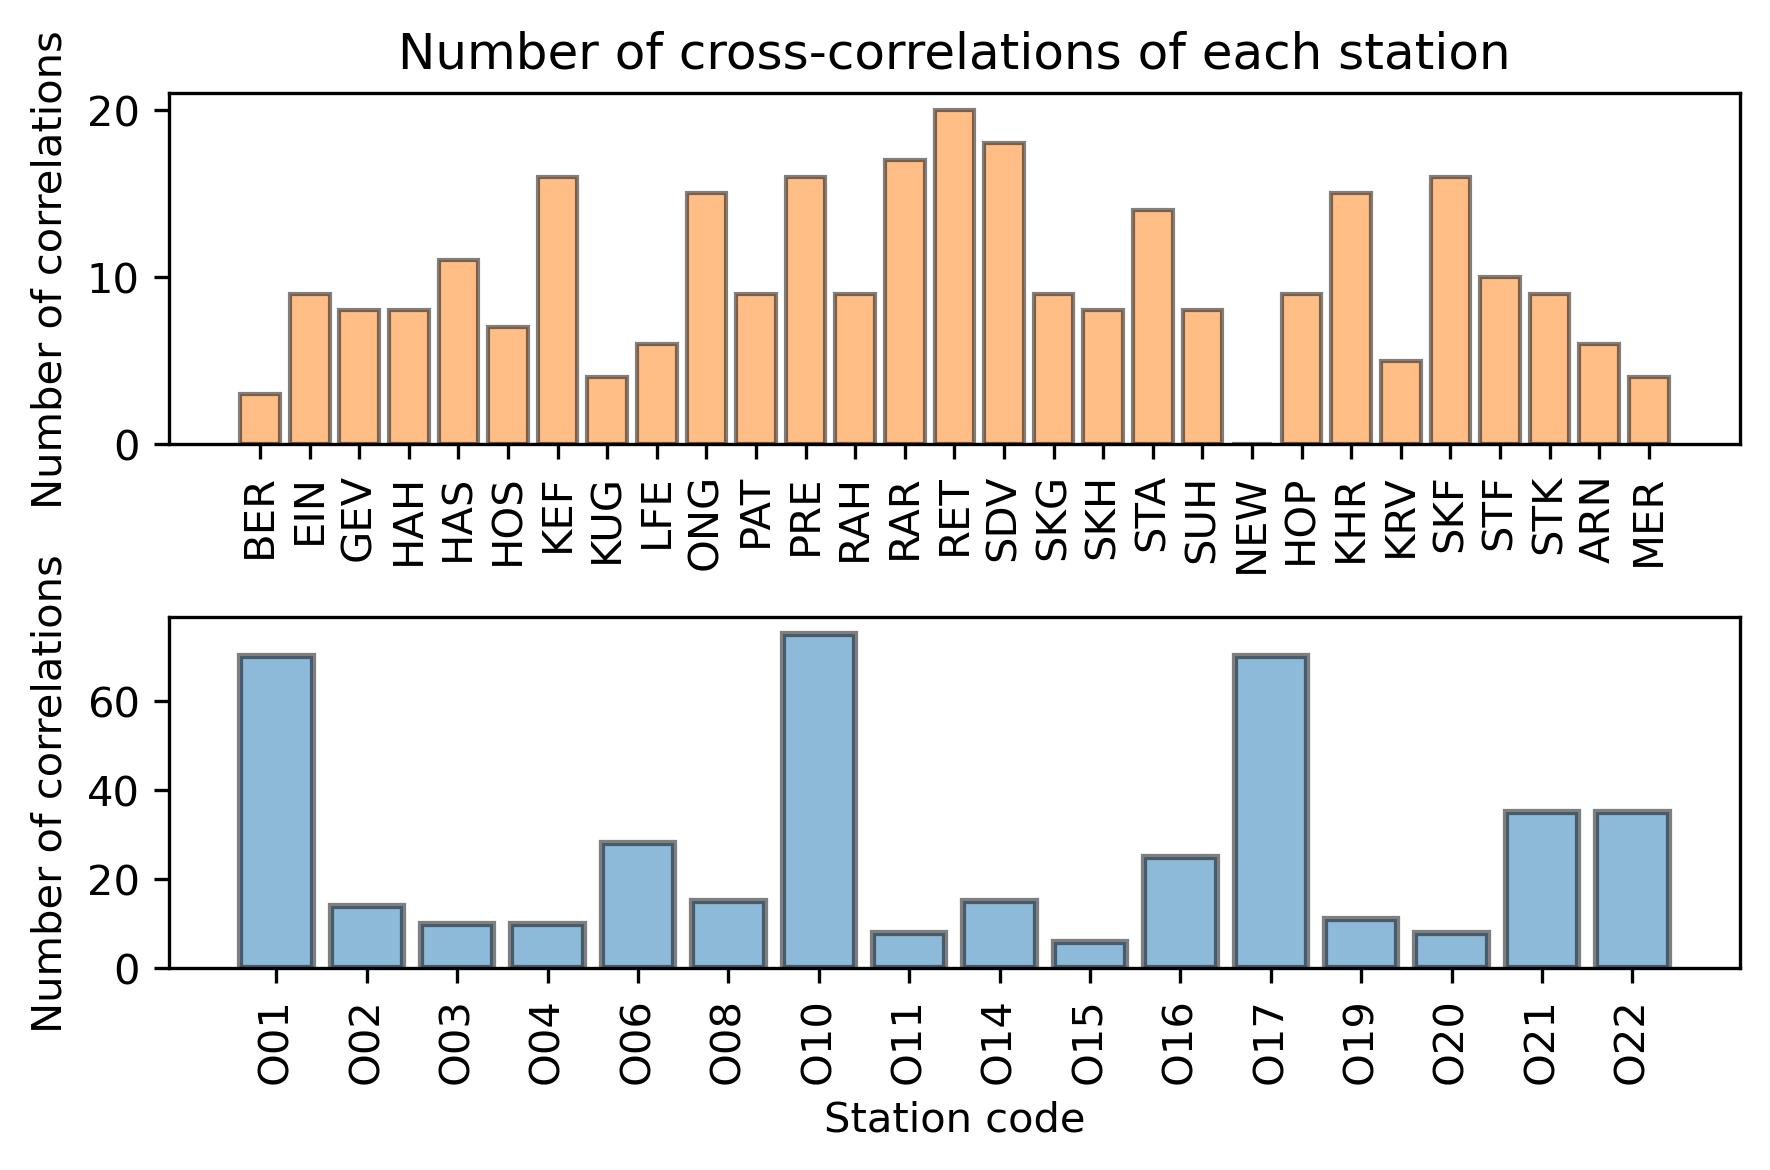

In [11]:
cd2 = cd.copy()
stations_with_few_corrs = ["O23"]
for sta_code in stations_with_few_corrs:
    correlations_2_remove = cd2.get_correlations_of_station(sta_code)
    station_2_remove = cd2.get_station(sta_code)
    for c in correlations_2_remove:
        cd2.correlations.remove(c)
    cd2.stations.remove(station_2_remove)
cd2.calculate_tapp_4_allcorrelations()
cd2.remove_outiers(max_error=1.)
cd2.plot_hist_no_correlations_per_station()

In [12]:
min_number_of_total_correlations = 2
min_number_correlation_periods = 2
min_number_of_stationconnections = 2
average_dates = [c.average_date for c in cd.correlations]
days_apart=(max(average_dates) - min(average_dates)) / (5 * 86400)

In [13]:
from ocloc import suppress_stdout
from statistics import mean
import numpy as np
average_dates = [c.average_date for c in cd.correlations]
mean_a_weighted = []
mean_b_weighted = []
mean_a_lstsq    = []
mean_b_lstsq    = []
#with suppress_stdout():
for i in range(10):
    bootstrapped_cd = cd.copy()
    correlations_with_tapp = []
    for c in bootstrapped_cd.correlations:
        if not np.isnan(c.t_app[-1]):
            correlations_with_tapp.append(c)
    index_list = np.random.choice(range(len(correlations_with_tapp)),
                                  replace=True,
                                  size=len(correlations_with_tapp))

    res_list = [correlations_with_tapp[i] for i in index_list]
    bootstrapped_cd.correlations = res_list
    bootstrapped_cd.filter_stations(min_number_of_total_correlations,
                                    min_number_correlation_periods, 
                                    min_number_of_stationconnections,
                                    days_apart)
    for _sta in bootstrapped_cd.stations:
        if not _sta.needs_correction:
            continue
        _corrs = bootstrapped_cd.get_correlations_of_station(_sta.code)
        _t_apps = [_c.t_app[-1] for _c in _corrs]
        if all(element == np.nan for element in _t_apps):
            print(sta, _t_apps)
            raise
    weighted_cd = bootstrapped_cd.copy()
    weighted_cd.calculate_dt_ins()
    weighted_cd.build_matrices()
    weighted_cd.solve_eq(method='weighted_lstsq')

    lstsq_cd = bootstrapped_cd.copy()
    lstsq_cd.calculate_dt_ins()
    lstsq_cd.build_matrices()
    lstsq_cd.solve_eq(method='lstsq')

    a_vals_weighted = []
    b_vals_weighted = []
    a_vals_lstsq    = []
    b_vals_lstsq    = []
    for station_w, station_l in zip(weighted_cd.stations,
                                    lstsq_cd.stations):
        if station_w.needs_correction:
            a_vals_weighted.append(station_w.a[-1])
            b_vals_weighted.append(station_w.b[-1])
        if station_l.needs_correction:
            a_vals_lstsq.append(station_l.a[-1])
            b_vals_lstsq.append(station_l.b[-1])
    mean_a_weighted.append(mean(a_vals_weighted))
    mean_b_weighted.append(mean(b_vals_weighted))
    mean_a_lstsq.append(mean(a_vals_lstsq))
    mean_b_lstsq.append(mean(b_vals_lstsq))

Station  O11 does not exceed the min. no. of correlation periods.
Station  O11 does not exceed the min_number_of_stationconnections
Station  O20 does not exceed the min. no. of correlation periods.
Station  O20 does not exceed the min_number_of_stationconnections
Station  O23 does not exceed the min_number_of_stationconnections
No t_app found for Station: O11
No t_app found for Station: O20
No t_app found for Station: O23
Calculating a and b for each station.
The weighting is done based on the station separation.
No t_app found for Station: O11
No t_app found for Station: O20
No t_app found for Station: O23
Calculating a and b for each station.
Station  O11 does not exceed the min. no. of correlation periods.
Station  O11 does not exceed the min_number_of_stationconnections
Station  O20 does not exceed the min. no. of correlation periods.
Station  O20 does not exceed the min_number_of_stationconnections
Station  O23 does not exceed the min_number_of_stationconnections
No t_app found fo

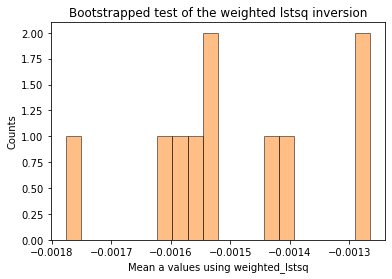

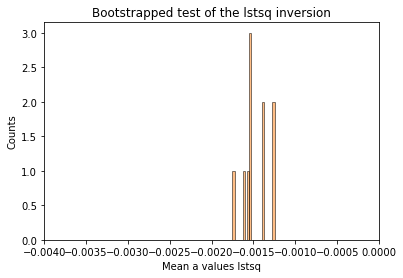

In [14]:
import matplotlib.pyplot as plt
plt.hist(mean_a_weighted, bins = 20,
        alpha=0.5,
        facecolor="C1",
        edgecolor="black",
        linewidth=1
        )
plt.title("Bootstrapped test of the weighted lstsq inversion")
plt.xlabel("Mean a values using weighted_lstsq")
plt.ylabel("Counts")
#plt.xlim(-0.02, 0.02)
plt.show()

plt.hist(mean_a_lstsq, bins = 20,
        alpha=0.5,
        facecolor="C1",
        edgecolor="black",
        linewidth=1
        )
plt.title("Bootstrapped test of the lstsq inversion")
plt.xlabel("Mean a values lstsq")
plt.ylabel("Counts")
plt.xlim(-0.004, 0.)
plt.show()



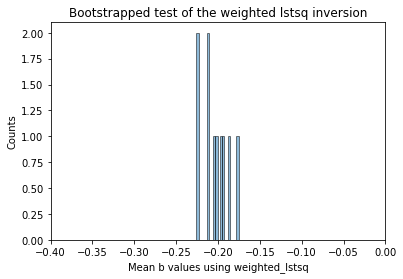

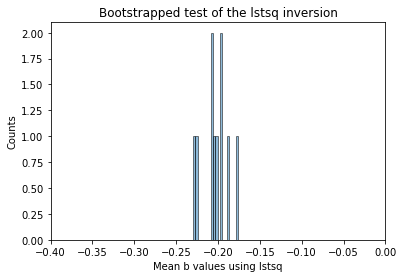

In [15]:
plt.hist(mean_b_weighted, bins = 20,
        alpha=0.5,
        facecolor="C0",
        edgecolor="black",
        linewidth=1
        )
plt.title("Bootstrapped test of the weighted lstsq inversion")
plt.xlabel("Mean b values using weighted_lstsq")
plt.ylabel("Counts")
plt.xlim(-0.4, 0)
plt.show()

plt.hist(mean_b_lstsq, bins = 20,
        alpha=0.5,
        facecolor="C0",
        edgecolor="black",
        linewidth=1
        )
plt.title("Bootstrapped test of the lstsq inversion")
plt.xlabel("Mean b values using lstsq")
plt.ylabel("Counts")
plt.xlim(-0.4, 0.)
plt.show()